In [4]:
import matplotlib.pyplot as plt
import gsw.density as gsw_d
import gsw.conversions as gsw_c
from gsw._wrapped_ufuncs import cp_t_exact
import xarray as xr
from netCDF4 import Dataset
import os
from numpy import ma
import numpy as np

npth='J:/ALL/myEN4_198001_202012_tsh.nc'

DATA=xr.open_dataset(npth).loc[dict(depth=slice(0,750))]

DEPTH,LAT,LON=DATA.depth,DATA.lat,DATA.lon 
SA,TEMP=DATA.salt,DATA.temp
DEPTH_BND=DATA['depth_bnds']

In [9]:
DZ=DEPTH_BND[:,1]-DEPTH_BND[:,0]

In [11]:
DZ

<xarray.DataArray 'depth_bnds' (depth: 24)>
array([ 10.0475  ,  10.068301,  10.0982  ,  10.1413  ,  10.2033  ,
        10.292297,  10.420204,  10.604195,  10.868401,  11.247604,
        11.791199,  12.569702,  13.682297,  15.267395,  17.516998,
        20.690811,  25.132095,  31.276794,  39.645218,  50.8013  ,
        65.25928 ,  83.32501 , 104.900696, 129.3208  ], dtype=float32)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 35.28 ... 373.0 446.8 540.5 657.3

In [9]:
def calc_ohc(DEPTH,LAT,LON,SA,TEMP,Abs_salt=True):
    '''
    All values --> xarray.dataarray 
    '''
    if Abs_salt:
        pass
    else:
        #Practical Salinity --> Absolute salinity
        SA = gsw_c.SA_from_SP(SA,DEPTH,LON,LAT) # [SA, in_ocean] = gsw_SA_from_SP(SP,p,long,lat)
    
    # Potential temp --> Conservative temp
    CT=gsw_c.CT_from_pt(SA,TEMP) #CT = gsw_CT_from_pt(SA,pt)
    rho = gsw_d.rho(SA,CT,DEPTH)

    # Potential temperature --> In-situ temperature
    t=gsw_c.t_from_CT(SA,CT,DEPTH)

    # Heat capacity
    CP = cp_t_exact(SA,t,DEPTH)
    
    CP,CT,rho=CP.values,CT.values,rho.values
    CP=(CP[:,1:,:,:]+CP[:,:-1,:,:])/2
    CT=(CT[:,1:,:,:]+CT[:,:-1,:,:])/2
    rho=(rho[:,1:,:,:]+rho[:,:-1,:,:])/2

    DZ=np.diff(DEPTH)
    
    T,D,A,O=CT.shape

    dz=np.tile(np.tile(np.tile(DZ.reshape([D,1]), A )\
                    .reshape([D,A,-1]), O), (T,1,1,1) )
    
    OHC_=CP*CT*rho*dz
    
    # Integrates from ref depth (2000m) 
    OHC=np.sum(OHC_,axis=1)

    return OHC

OHC=calc_ohc(DEPTH,LAT,LON,SA,TEMP,Abs_salt=True)


c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in rho
  result_data = func(*input_data)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in rho
  result_data = func(*input_data)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in t_from_ct
  result_data = func(*input_data)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in t_from_ct
  result_data = func(*input_data)


In [12]:
from numpy import ma

mask=(OHC!=OHC).data
OHC=ma.array(OHC,mask=mask)

In [13]:
OHC

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [123930610.58591726, 205920582.260322, 272697750.92317176, ...,
          -117707393.38231416, -42328031.2858825, 37180352.22979993],
         [37297809.73024511, 84059487.37381469, 119829202.29644446, ...,
          -108075319.24425976, -60396629.600572646, -12743757.2701623],
         [-26096274.836237267, -4277945.626168802, 9250004.172960028,
          ..., -103732851.67115618, -77249758.08455932,
          -50211029.93533565]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [10906744.978776917, 95398783.12754506, 168092494.7282607, ...,
          -254914865.23093516, -171820588.4876985, -83215523.56172176],
         [-170154032.3152737, -118563463.73914793, -76550527.8399391,
          ..., -328773442.84420055, -278877581.6007624,


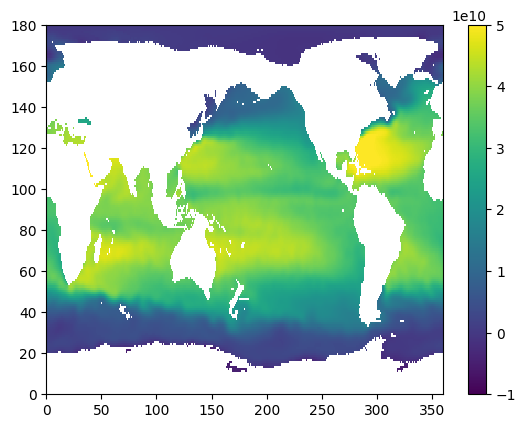

In [9]:
import matplotlib.pyplot as plt
plt.pcolormesh(OHC[0],vmin=-1*10**10,vmax=5*10**10)
plt.colorbar()

In [1]:
np.nansum(OHC[0])

NameError: name 'np' is not defined